# Import Libraries and Constants

In [85]:
%matplotlib inline
import torch as th
#import torch.nn.functional as F
import torch.nn as nn 
import pandas as pd
import numpy as np
from sklearn.metrics import mean_poisson_deviance, d2_tweedie_score
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import utils
import architecture
import run_config
import csv
from pandas._libs.lib import is_integer
from numpy import genfromtxt
from statistics import mean

In [86]:
FL_NUM_UNITS_1 = 15

In [87]:
FL_NUM_UNITS_2 = 20

In [88]:
NUM_FEATURES = 39

# Test FL Models Against Validation

In [89]:
def create_val_data(agent): 
    
        MY_DATA_PATH = '../data'

        X_val_sc = genfromtxt(MY_DATA_PATH + '/X_val_'+str(agent)+'.csv', delimiter=',', skip_header=1)
        y_val_sc = genfromtxt(MY_DATA_PATH + '/y_vl_'+str(agent)+'.csv', delimiter=',', skip_header=1)

        return X_val_sc, y_val_sc

In [90]:
def model_val_test(path):
    
    # Load Model
    
    FL_PATH_MODEL = path
    fl_model = architecture.MultipleRegression(num_features=NUM_FEATURES, num_units_1=FL_NUM_UNITS_1, num_units_2=FL_NUM_UNITS_2)
    fl_model.load_state_dict(th.load(FL_PATH_MODEL))
    fl_model.eval()

    # Test FL model against validation data
    
    val_perf_list = []
    for agent in range(0,10):
        X_val, y_val= create_val_data(agent)
        y_fl_pred = fl_model.predict(th.tensor(X_val).float())
        y_fl_pred = pd.Series(y_fl_pred.flatten().detach().numpy())
        fl_weighted_pde = d2_tweedie_score(y_val, y_fl_pred, sample_weight=X_val[:, 0], power=1)
        val_perf_list.append(fl_weighted_pde)

    return mean(val_perf_list)

# Graph Results

In [91]:
# initialize list of lists
data = [[25, model_val_test('../ag_0/fl_model_UP_10ag_25rnd_10ep_0qt_0SMPCn.pt')], 
        [50, model_val_test('../ag_0/fl_model_UP_10ag_50rnd_10ep_0qt_0SMPCn.pt')], 
        [100, model_val_test('../ag_0/fl_model_UP_10ag_100rnd_10ep_0qt_0SMPCn.pt')], 
        [125, model_val_test('../ag_0/fl_model_UP_10ag_125rnd_10ep_0qt_0SMPCn.pt')], 
        [150, model_val_test('../ag_0/fl_model_UP_10ag_150rnd_10ep_0qt_0SMPCn.pt')], 
        [200, model_val_test('../ag_0/fl_model_UP_10ag_200rnd_10ep_0qt_0SMPCn.pt')], 
        [250, model_val_test('../ag_0/fl_model_UP_10ag_250rnd_10ep_0qt_0SMPCn.pt')], 
        [300, model_val_test('../ag_0/fl_model_UP_10ag_300rnd_10ep_0qt_0SMPCn.pt')], 
        [350, model_val_test('../ag_0/fl_model_UP_10ag_350rnd_10ep_0qt_0SMPCn.pt')], 
        [400, model_val_test('../ag_0/fl_model_UP_10ag_400rnd_10ep_0qt_0SMPCn.pt')], 


        ]
 
# Create the pandas DataFrame
df_val_results = pd.DataFrame(data, columns=['Rounds', 'Validation Loss'])

In [92]:
df_val_results

,Rounds,Validation Loss
0,25,0.045382
1,50,0.047197
2,100,0.048499
3,125,0.049491
4,150,0.050757
5,200,0.052991
6,250,0.053865
7,300,0.054019
8,350,0.054110
9,400,0.054034


/var/folders/ch/ynbycfmj4cd7vcc24hv_f7fr0000gn/T/ipykernel_6614/189600105.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


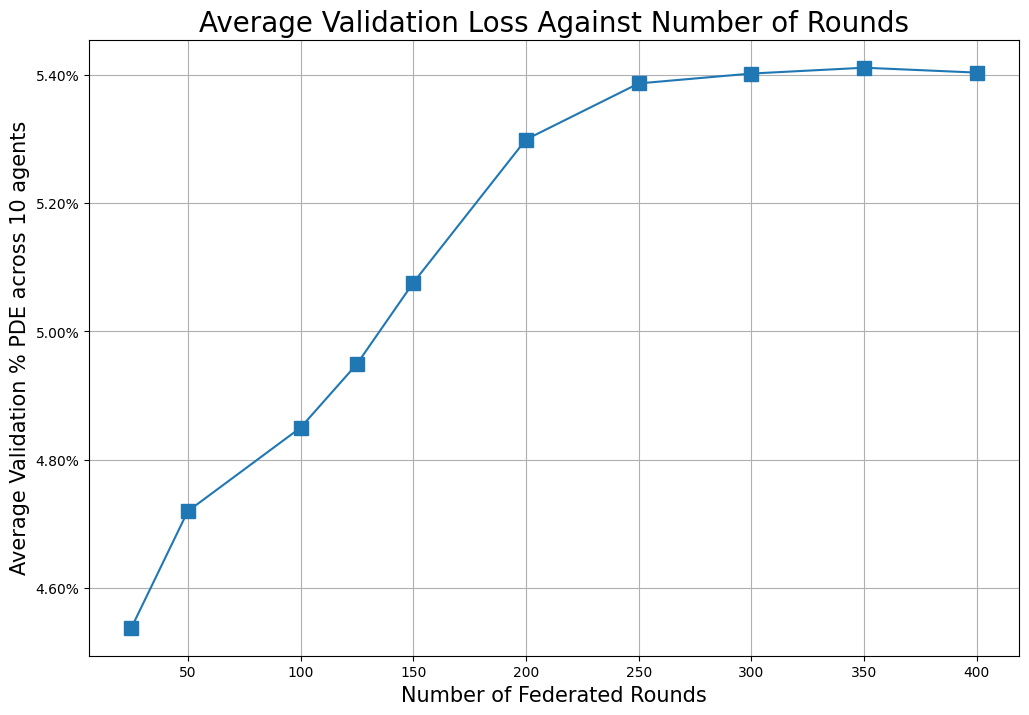

In [93]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(df_val_results['Rounds'],
         df_val_results['Validation Loss'], 
         #linestyle = 'dotted',
         marker='s',
         markersize=10,
         )

plt.xlabel('Number of Federated Rounds', fontsize=15)
plt.ylabel('Average Validation % PDE across 10 agents', fontsize=15)
plt.title('Average Validation Loss Against Number of Rounds', fontsize=20)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

plt.grid()